In [1]:
!pip install git+https://github.com/microsoft/dowhy.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 20.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets
import statsmodels.api as sm

In [3]:
np.random.seed(42)


In [4]:
data_dict = dowhy.datasets.linear_dataset(
    beta=2,
    num_common_causes=2,
    num_discrete_common_causes=1,
    num_instruments=1,
    num_samples=5000,
    treatment_is_binary=True
)

data_df = data_dict["df"]



In [5]:
causal_graph = """
digraph {
    Treatment -> Outcome;
    Confounder1 -> Treatment;
    Confounder2 -> Treatment;
    Instrument1 -> Treatment;
    Confounder1 -> Outcome;
    Confounder2 -> Outcome;
}
"""

causal_model = CausalModel(
    data=data_df,
    treatment=data_dict["treatment_name"],
    outcome=data_dict["outcome_name"],
    graph=data_dict["gml_graph"]
)


In [6]:
X = sm.add_constant(data_df[data_dict["treatment_name"]].astype(float))
Y = data_df[data_dict["outcome_name"]].astype(float)
ols_model = sm.OLS(Y, X).fit()
print(ols_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1626      0.022     -7.472      0.000      -0.205      -0.120
v0             2.0819      0.027     78.483      0.000       2.030       2.134


In [7]:
identified_estimand = causal_model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)



In [8]:
causal_estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

## Realized estimand
b: y~v0+W1+W0
Target units: ate

## Estimate
Mean value: 2.0006810477949495



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.12/dist-packages/dowhy/causal_refuters/add_unobserved_common_cause.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_dev_y = np.std(y)[0]
/usr/local/lib/python3.12/dist

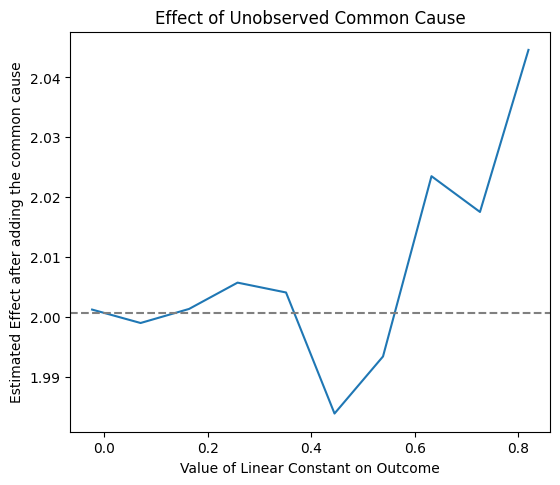

Refute: Add an Unobserved Common Cause
Estimated effect:2.0006810477949495
New effect:(np.float64(1.983823755030339), np.float64(2.0445949294510606))



In [9]:
refutation_test = causal_model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="add_unobserved_common_cause"
)
print(refutation_test)


In [10]:
iv_estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable"
)
print(iv_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡ d    ⎤ 
E⎢───(y)⎥ 
 ⎣dZ₀   ⎦ 
──────────
 ⎡ d     ⎤
E⎢───(v₀)⎥
 ⎣dZ₀    ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and ['y']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['y'] is affected in the same way by com

In [ ]:
D